In [1]:
from collections import Counter
from zipfile import ZipFile
from tqdm import tqdm
import random as rn
import os
import requests
import os
import sys
from urllib.request import urlretrieve
import numpy as np
import nltk
from nltk import word_tokenize

class GloveMatrix(object):
    """
    Downloads and loads GloVe matrix.
    """
    def __init__(self):
        self.glove_url = "http://nlp.stanford.edu/data/glove.6B.zip"
        self.file_name = "glove.6B.zip"
        self.dest = "glove.6B"
        self.download_glove()
        embedding_index = self.load_matrix()
        self.EMBEDDING_DIM = 300
        print("Done")
        
    def download_glove(self):
        if not os.path.exists("glove.6B/glove.6B.300d.txt"):
            if os.path.exists(self.file_name):
                self.unzip_file(self.file_name, self.dest)
            else:
                urlretrieve(self.glove_url, self.file_name, self.reporthook)
                self.unzip_file(self.file_name, self.dest)
                
    def load_matrix(self):       
        print("Loading embedding matrix")
        self.embedding_index = {}
        with open('glove.6B/glove.6B.300d.txt', "r") as f:
            lines = f.read().split("\n")
            for line in lines:
                values = line.split()
                if len(values) > 0:
                    word = values[0]
                    coefs = np.asarray(values[1:], dtype='float32')
                    self.embedding_index[word] = coefs

    def get_index(self):
        return self.embedding_index    

    def unzip_file(self, file_name, dest):
        print("Unzipping file...")
        zipTest = ZipFile(file_name)
        zipTest.extractall(dest)

    def download_file(self, url, file_name):
        print("Downloading file...")
        urlretrieve(url, file_name, reporthook)

    def reporthook(self, blocknum, blocksize, totalsize):
        readsofar = blocknum * blocksize
        if totalsize > 0:
            percent = readsofar * 1e2 / totalsize
            s = "\r%5.1f%% %*d / %d" % (
                percent, len(str(totalsize)), readsofar, totalsize)
            sys.stderr.write(s)
            if readsofar >= totalsize: # near the end
                sys.stderr.write("\n")
        else: # total size is unknown
            sys.stderr.write("read %d\n" % (readsofar,))

class TextEmbedder(object):
    """
    TextEmbedder returning word embeddings, using given GloVe matrix.
    """
    def __init__(self, glove_matrix):
        self.embedding_index = glove_matrix.embedding_index

    def get_any(self,word):
         return self.embedding_index.get(word, self.embedding_index.get("unk"))

In [2]:
import pickle
import matplotlib.pyplot as plt
import sys
import csv
import string
import time
from scipy import stats

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /homes/tam66/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
gm = GloveMatrix()
te = TextEmbedder(gm)

Loading embedding matrix
Done


In [5]:
# getting word embedding for one word
ex = te.get_any("hello")
len(ex)

300

In [8]:
start_time = time.time()
end_time = time.time()
duration = end_time - start_time
print(f'It took {round(duration,5)} to run')

It took 5e-05 to run


In [9]:
start_time = time.time()

i = 0
with open('final.csv', mode='r',encoding = 'ISO-8859-1') as csv_sentences:
    sentences = csv.reader(csv_sentences)
    for sentence in sentences:
        print(sentence)
        embedded_sentence = []
        
        for word in sentence:
            embedded_sentence.append(te.get_any(word))
            result = np.vstack(embedded_sentence)
            
        #print (result)
        if i == 2:
            break
        i += 1

['anthony', 'gilbert', 'the', 'pen', 'name', 'of', 'lucy', 'beatrice', 'malleson', '15', 'february', '1899', '9', 'december', '1973', 'was', 'an', 'english', 'crime', 'writer', 'who', 'was', 'a', 'cousin', 'of', 'actorscreenwriter', 'miles', 'malleson']
['she', 'also', 'wrote', 'nongenre', 'fiction', 'as', 'anne', 'meredith', 'and', 'published', 'one', 'crime', 'novel', 'and', 'an', 'autobiography', 'threeapenny', '1940', 'under', 'the', 'meredith', 'name']
['she', 'published', '69', 'crime', 'novels', '51', 'of', 'which', 'featured', 'her', 'bestknown', 'character', 'arthur', 'crook']


## Stentence stats

In [10]:
i = 0
array_length = 1e6
length = np.zeros(int(array_length))

with open('final.csv', mode='r',encoding = 'ISO-8859-1') as csv_sentences:
    sentences = csv.reader(csv_sentences)
    for sentence in sentences:

        length[i] = len(sentence)
        
        if i % (int(array_length)/10) == 0:
            print(i)
        if i == int(array_length) - 1:
            break
        i += 1

0
100000
200000
300000
400000
500000
600000
700000
800000
900000


In [11]:
stats.mode(length)

ModeResult(mode=array([ 15.]), count=array([42904]))

In [12]:
length.mean()

19.863333999999998

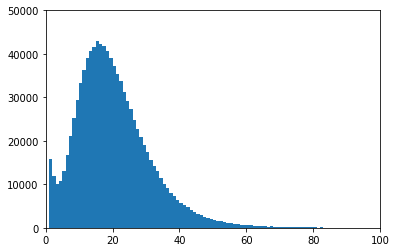

In [13]:
plt.hist(length,bins=100,range=[0,100])
plt.axis([0, 100, 0, 5e4])
plt.show()

## Length-40 embeddings

In [14]:
result = np.zeros([10,40,300])

In [15]:
len(result[0][0])

300

In [18]:
! pwd

/homes/tam66/Documents/lent/adv_ml/wiki


In [56]:
i = 0
max_i = 1e4
num_files = 10

k = 0
path = '/homes/tam66/Documents/lent/adv_ml/wiki/embeddings/'
this_path = path + str(k) + '.pkl'
out_file = open(this_path, 'wb') 

result = np.zeros([int(max_i),40,300])

with open('final.csv', mode='r',encoding = 'ISO-8859-1') as csv_sentences:
    sentences = csv.reader(csv_sentences)
    for sentence in sentences:

        # truncate to 40 words if longer
        if len(sentence) > 40:
            sentence = sentence[:40]

        # write zero vector to result if the sentence ends before 40
        for j in range(40):
            try:
                result[i][j] = te.get_any(sentence[j])
            except:
                result[i][j] = np.zeros(300)
            j += 1

        i += 1
        
        #if i % 1e3 == 0:
        #    print(i)
        
        if i == max_i:
            pickle.dump(result, out_file)
            out_file.close()
            print(k)
            k += 1
            if k < num_files:
                this_path = path + str(k) + '.pkl'
                out_file = open(this_path, 'wb') 
                result = np.zeros([int(max_i),40,300])
            else:
                print('done')
                break
            i = 0
 

0
1
2
3
4
5
6
7
8
9
done


In [57]:
from sys import getsizeof

In [59]:
getsizeof(result) / 1e9

0.960000128

In [39]:
len(result)

1000000

In [36]:
k

1

In [45]:
results[0][0][0]

0.0024874999653548002

In [46]:
len(results)

10

In [63]:
k = 2
path = '/homes/tam66/Documents/lent/adv_ml/wiki/embeddings/'
this_path = path + str(k) + '.pkl'
data = pickle.load(open(this_path,'rb'))

In [67]:
len(data[0][0])

300

In [74]:
data[0][12]

array([-0.12888999, -0.64595002,  0.41049001, -0.058506  ,  0.22505   ,
       -0.58323997,  0.56036001,  0.18669   ,  0.75523001,  0.078054  ,
       -0.20029999,  0.096644  , -0.22208001, -0.23299   ,  0.31848001,
        0.10687   , -0.39561999, -0.49674001, -0.017072  ,  0.049282  ,
       -0.041442  , -0.02056   ,  0.31292   ,  0.15335   , -0.54505998,
        0.45374   , -0.31419   ,  0.21009   ,  0.16415   ,  0.57090998,
        0.24864   ,  0.39919001,  0.23466   ,  0.51599997, -1.1789    ,
        0.50709999, -0.34211001,  0.03859   , -0.51209003, -0.51617002,
       -0.25312001,  0.42034   , -0.41055   ,  0.068451  ,  0.42642999,
        0.13366   ,  0.29521   ,  0.39919999, -0.2836    , -0.04765   ,
       -0.46186   , -0.20874999, -0.36179   , -0.21145999,  0.45943001,
       -0.12837   , -0.031208  , -0.18989   ,  0.014506  , -0.56633002,
        0.12513   , -0.26820001,  0.30306   ,  0.30724001,  0.66386002,
       -0.27034   , -0.10429   , -0.13256   , -0.27869999, -0.73

In [15]:
i = 0
with open('final.csv', mode='r',encoding = 'ISO-8859-1') as csv_sentences:
    sentences = csv.reader(csv_sentences)
    for sentence in sentences:
        print(sentence)
        i += 1
        
        if i == 5:
            break

['anthony', 'gilbert', 'the', 'pen', 'name', 'of', 'lucy', 'beatrice', 'malleson', '15', 'february', '1899', '9', 'december', '1973', 'was', 'an', 'english', 'crime', 'writer', 'who', 'was', 'a', 'cousin', 'of', 'actorscreenwriter', 'miles', 'malleson']
['she', 'also', 'wrote', 'nongenre', 'fiction', 'as', 'anne', 'meredith', 'and', 'published', 'one', 'crime', 'novel', 'and', 'an', 'autobiography', 'threeapenny', '1940', 'under', 'the', 'meredith', 'name']
['she', 'published', '69', 'crime', 'novels', '51', 'of', 'which', 'featured', 'her', 'bestknown', 'character', 'arthur', 'crook']
['crook', 'is', 'a', 'vulgar', 'london', 'lawyer', 'totally', 'and', 'deliberately', 'unlike', 'the', 'sophisticated', 'detectives', 'such', 'as', 'lord', 'peter', 'wimsey', 'and', 'philo', 'vance', 'who', 'dominated', 'the', 'mystery', 'field', 'when', 'gilbert', 'introduced', 'him']
['instead', 'of', 'dispassionately', 'analyzing', 'a', 'case', 'he', 'usually', 'enters', 'it', 'after', 'seemingly', 'da